# 5 Class Activation Mapping

In [1]:
import numpy as np
from keras.applications import inception_v3
from keras.models import Model, load_model
from skimage import io, transform
import pandas as pd
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Preprocessing functions for images
def preprocess_im(im, input_size=(299, 299, 3)):
    im = transform.resize(im, output_shape=input_size)
    im = im * 255.0
    im = inception_v3.preprocess_input(im)
    return np.expand_dims(im, axis=0)

# Rescale array to 0-1
def rescale_arr(arr):
    min_, max_ = np.min(arr), np.max(arr)
    arr = arr - min_
    arr = arr / (max_ - min_)
    return arr  

In [3]:
# Load the model
model = load_model('./models/model_foodvsnot_v2.h5')
# Get the model to get the maps
model_maps = Model(inputs=model.input, outputs=model.layers[-3].input)

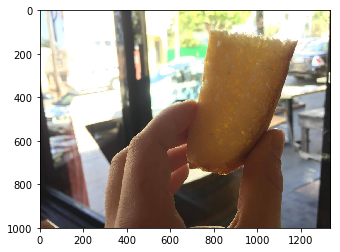

In [4]:
# Load a test image
# im = io.imread('../datasets/Food-5K/evaluation/1_416.jpg')
im = io.imread('./data/additional-images/2.jpg')
plt.imshow(im)

In [5]:
# Get the maps
maps = model_maps.predict(preprocess_im(im))
maps = np.squeeze(maps)

# Get the weights (to scale each map)
layer_weights = model.layers[-1].get_weights()[0]  # Weights of the FC layer
scaling_weights = layer_weights[:, 1]

# Multiply 
scaled_maps = maps * scaling_weights
print 'scaled_maps.shape', scaled_maps.shape

# Take mean
cam_map = np.mean(scaled_maps, axis=2)
print 'cam_map.shape:', cam_map.shape

# Resize it back to original image size
cam_map = rescale_arr(cam_map)
cam_map = transform.resize(cam_map, output_shape=im.shape[:-1])
print 'cam_map.shape:', cam_map.shape

/home/can/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


scaled_maps.shape (8, 8, 2048)
cam_map.shape: (8, 8)
cam_map.shape: (1000, 1334)


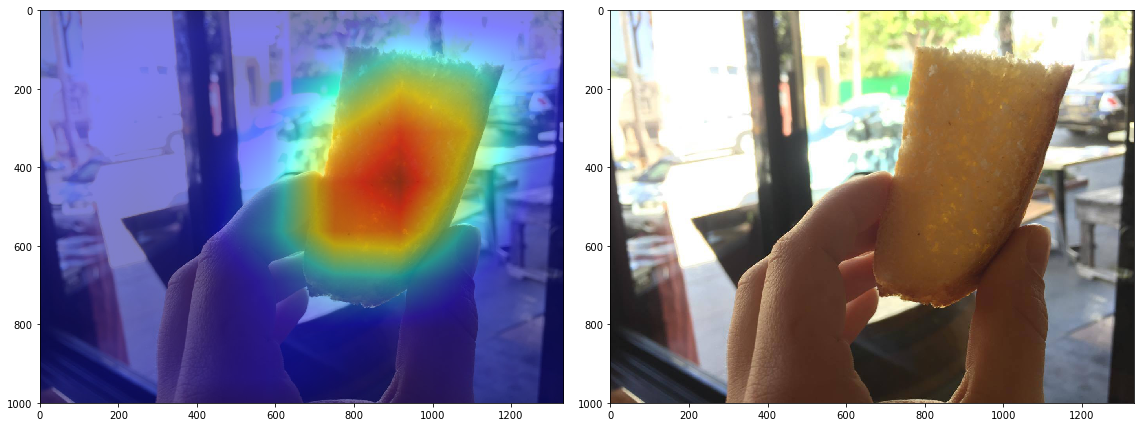

In [6]:
# Show it superimposed on heatmap
heatmap = cv2.applyColorMap((cam_map * 255.0).astype(np.uint8), cv2.COLORMAP_JET)[..., ::-1]
# Plot
fig = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow((im / 255.0) * 0.5 + (heatmap / 255.0) * 0.5)
plt.subplot(1,2,2); plt.imshow(im)
plt.tight_layout()

In [7]:
# Prediction score
model.predict(preprocess_im(im))[0, 1]

0.86831176

In [152]:
# k-means

In [153]:
# # Visualize maps
# fig = plt.figure(figsize=(25, 25))
# for i in range(1024):
#     plt.subplot(32, 32, i+1)
#     plt.imshow(maps[..., i])    
#     plt.axis('off')
# # plt.tight_layout()

In [154]:
# Make X_maps
X_maps = []
for i in range(maps.shape[-1]):
    X_maps.append(maps[..., i].flatten())
X_maps = np.array(X_maps)
print 'X_maps.shape:', X_maps.shape

# Do Clustering
k = 2
k_means_model = KMeans(n_clusters=k, n_jobs=-1)
k_means_model.fit(X_maps)
labels = k_means_model.predict(X_maps)
print 'labels.shape:', labels.shape
print pd.Series(labels).value_counts()
labels

X_maps.shape: (2048, 64)
labels.shape: (2048,)
1    1546
0     502
dtype: int64


array([1, 1, 1, ..., 1, 0, 1], dtype=int32)

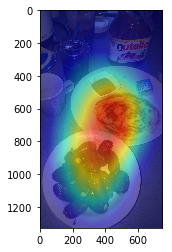

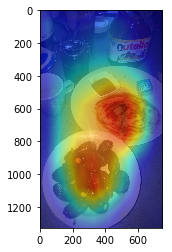

In [155]:
for label in range(k):
    map_label = np.mean(maps[..., labels == label], axis=2)
    map_label = rescale_arr(map_label)  # Rescale values
    map_label = transform.resize(map_label, output_shape=im.shape[:-1])  # Resize it to match the original image size
    map_heatmap = cv2.applyColorMap((map_label * 255.0).astype(np.uint8), cv2.COLORMAP_JET)[..., ::-1]
    # Plot
    fig = plt.figure()
    plt.imshow((im / 255.0) * 0.5 + (map_heatmap / 255.0) * 0.5)

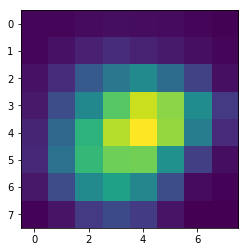

In [156]:
# 0
label = 0
map_0 = np.mean(maps[..., labels == label], axis=2)
plt.imshow(map_0)

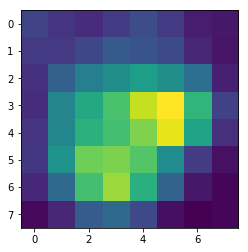

In [157]:
m1 = k_means_model.cluster_centers_[1]
m1 = m1.reshape(8, 8)
plt.imshow(m1)